### Plot Signals

In [88]:
import pandas as pd
import numpy as np
import plotting_util
import random
from datetime import datetime

STATES = ['above', 'below', 'sober']

SCENARIOS = ['highway', 'rural', 'town']

df = pd.read_parquet("out/can_data.parquet")
s_id = random.choice(np.unique(df['subject_id']))
state = random.choice(STATES)
scenario = random.choice(SCENARIOS)
can_data_subject = can_data[
    (can_data['subject_id'] == s_id) & 
    (can_data['subject_state'] == state) & 
    (can_data['subject_scenario'] == scenario)
    ]

6822    34.13
6823    34.13
6824    34.13
6825    32.42
6826    31.23
6827    26.66
6828    24.53
6829    19.54
6830    16.22
6831    13.81
6832    12.84
6833    12.55
6834    12.48
6835    12.46
6836    12.70
6837    12.74
6838    12.75
6839    12.75
6840    12.75
6841    12.75
6842    12.75
6843    12.75
Name: brake, dtype: float64


In [ ]:
%matplotlib widget
times = subject['timestamp']

fig, ax = plotting_util.create_plot(1, 1, constrained_layout=True)
ax[0].plot(times, subject['steer'])
plotting_util.set_figure_size(fig, 20, 5)
plotting_util.set_ax_yticks(ax[0], [-50, -5, 0, 5, 50], ['-50', '-5', '0', '5', '50'])

In [ ]:
from math import ceil

times = subject['timestamp']

nr_df_cols = len(subject.iloc[:, 5:].columns)
nr_rows = ceil(nr_df_cols / 2.0)
nr_cols = 2

fig, axes = plotting_util.create_plot(nr_rows, nr_cols, True, False, constrained_layout=True)
for axs, row in zip(axes, list(range(nr_rows))):
    for ax, col in zip(axs, list(range(nr_cols))):
        plotting_util.set_ax_axis_labels(ax, '', '')
        plotting_util.set_ax_title(ax, subject.iloc[:, 4+2*row+col].name)
        ax.plot(times, subject.iloc[:, 4+2*row+col])
plotting_util.set_figure_size(fig, 20, 50)

### Plot Segment Positions

In [ ]:
import pandas as pd
import plotting_util
%matplotlib widget
lanes_df = pd.read_csv('out/scenario_information.csv')
lanes_df = lanes_df.loc[lanes_df['scenario'] == 'highway']
fig, ax = plotting_util.create_plot(1,1)
for _, row in lanes_df.iterrows():
    ax.plot([row['StartPos_x_segment'], row['EndPos_x_segment']], [row['StartPos_y_segment'], row['EndPos_y_segment']], 'o-')
plotting_util.set_figure_size(fig, 20, 20)

### ID Image Thresholding

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv

img = cv.imread('out/20210901_d-011_above/error_segment_1927394.0.jpg')
imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
mask = cv.inRange(imhsv, (0, 50, 0), (179, 255, 255))
img_no_artifacts = cv.bitwise_and(img, img, mask=mask)
imgray = cv.cvtColor(img_no_artifacts, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(imgray, 127, 255, cv.THRESH_BINARY)
plt.imshow(thresh)

### None Counting for Segment IDs

In [ ]:
import pandas as pd
import glob
import re


DATA_FOLDER = '/adar/drive/study'

subject_folders = sorted(glob.glob(DATA_FOLDER + '/*_sober') + glob.glob(DATA_FOLDER + '/*_above') + glob.glob(
            DATA_FOLDER + '/*_below'))
subject_folders = [f for f in subject_folders if 'audio' not in f]

scenarios = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')

subject_re = re.compile('d-([0-9]+)')
for subject in subject_folders:
    subject_id_match = subject_re.search(subject)
    if not subject_id_match:
        continue
    subject_id = subject_id_match.group(1)

    if "drunk" in subject:
        state = "drunk"
    elif "above" in subject:
        state = "above"
    elif "below" in subject:
        state = "below"
    else:
        state = "sober"

    for scenario in scenarios: 
        can_data_for_subject = can_data.loc[(can_data['subject_id'] == subject_id) & (can_data['subject_state'] == state) & (can_data['subject_scenario'] == scenario)]
        print('subject_id: {}, state: {}, scenario: {}'.format(subject_id, state, scenario))
        print(can_data_for_subject['segment_id'].isna().sum())

### Lane Position Validation

In [ ]:
import pandas as pd
import glob
import re
import cv2 as cv
import random
import datetime
import pytz
import os

DATA_FOLDER = '/adar/drive/study'

subject_folders = sorted(glob.glob(DATA_FOLDER + '/*_sober') + glob.glob(DATA_FOLDER + '/*_above') + glob.glob(
            DATA_FOLDER + '/*_below'))
subject_folders = [f for f in subject_folders if 'audio' not in f]

selected_folders = random.sample(subject_folders, 5)
scenarios = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')

subject_re = re.compile('d-([0-9]+)')
timestamp_re = re.compile(r'(\d{4})-(\d{2})-(\d{2})--(\d{2})-(\d{2})-(\d{2}).flv')
for subject in selected_folders:
    subject_id_match = subject_re.search(subject)
    if not subject_id_match:
        continue
    subject_id = subject_id_match.group(1)

    if "drunk" in subject:
        state = "drunk"
    elif "above" in subject:
        state = "above"
    elif "below" in subject:
        state = "below"
    else:
        state = "sober"

    scenario = random.choice(scenarios)
    can_data_for_subject = can_data.loc[(can_data['subject_id'] == subject_id) & (can_data['subject_state'] == state) & (can_data['subject_scenario'] == scenario)]

    print('subject folder: {}, subject_id: {}, state: {}, scenario: {}'.format(subject, subject_id, state, scenario))
    
    for video in glob.glob(subject + '/obs-videos/*[!_cropped].flv'):
        print('video: {}'.format(video.split('/')[-1]))
        match = timestamp_re.search(video.split('/')[-1])
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
            day = int(match.group(3))
            hour = int(match.group(4))
            minute = int(match.group(5))
            second = int(match.group(6))
            video_timestamp = datetime.datetime(year, month, day, hour, minute, second)
            tz = pytz.timezone('Europe/Zurich')
            video_timestamp = tz.localize(video_timestamp)
            can_data_lane = can_data_for_subject[['timestamp', 'latpos', 'segment_id', 'lane_number', 'lane_position', 'lane_distance_left_edge', 'lane_distance_right_edge']].copy()
            can_data_lane.loc[:, 'timestamp'] = (can_data_lane['timestamp'] - video_timestamp) / datetime.timedelta(milliseconds=1)
            sampled_values = can_data_lane.sample(10).sort_values(by='timestamp').to_numpy()
            cap = cv.VideoCapture(video)
            index = 0
            for timestamp_ms, latpos, segment_id, lane_nr, lane_pos, distance_left_edge, distance_right_edge in sampled_values:
                folder = 'out/' + subject.split('/')[-1]
                if not os.path.exists(folder):
                    os.makedirs(folder)
                is_set = cap.set(cv.CAP_PROP_POS_MSEC, timestamp_ms)
                if is_set:
                    success, frame = cap.read()
                    if success:
                        print('success')
                        img = cv.putText(frame, 'latpos: {}'.format(latpos), (1300, 1200), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(frame, 'segment id: {}'.format(segment_id), (1300, 1300), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane nr: {}'.format(lane_nr), (1300, 1400), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane pos: {}'.format(lane_pos), (1300, 1500), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'distance left edge: {}'.format(distance_left_edge), (1300, 1600), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'distance right edge: {}'.format(distance_right_edge), (1300, 1700), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        cv.imwrite(folder + '/img{}-{}-{}.png'.format(index, scenario, timestamp_ms / 1000.0), img)
                        index += 1
                    else:
                        print('could not get frame')
                else:
                    print('could not set video timestamp')

### Event Visualization

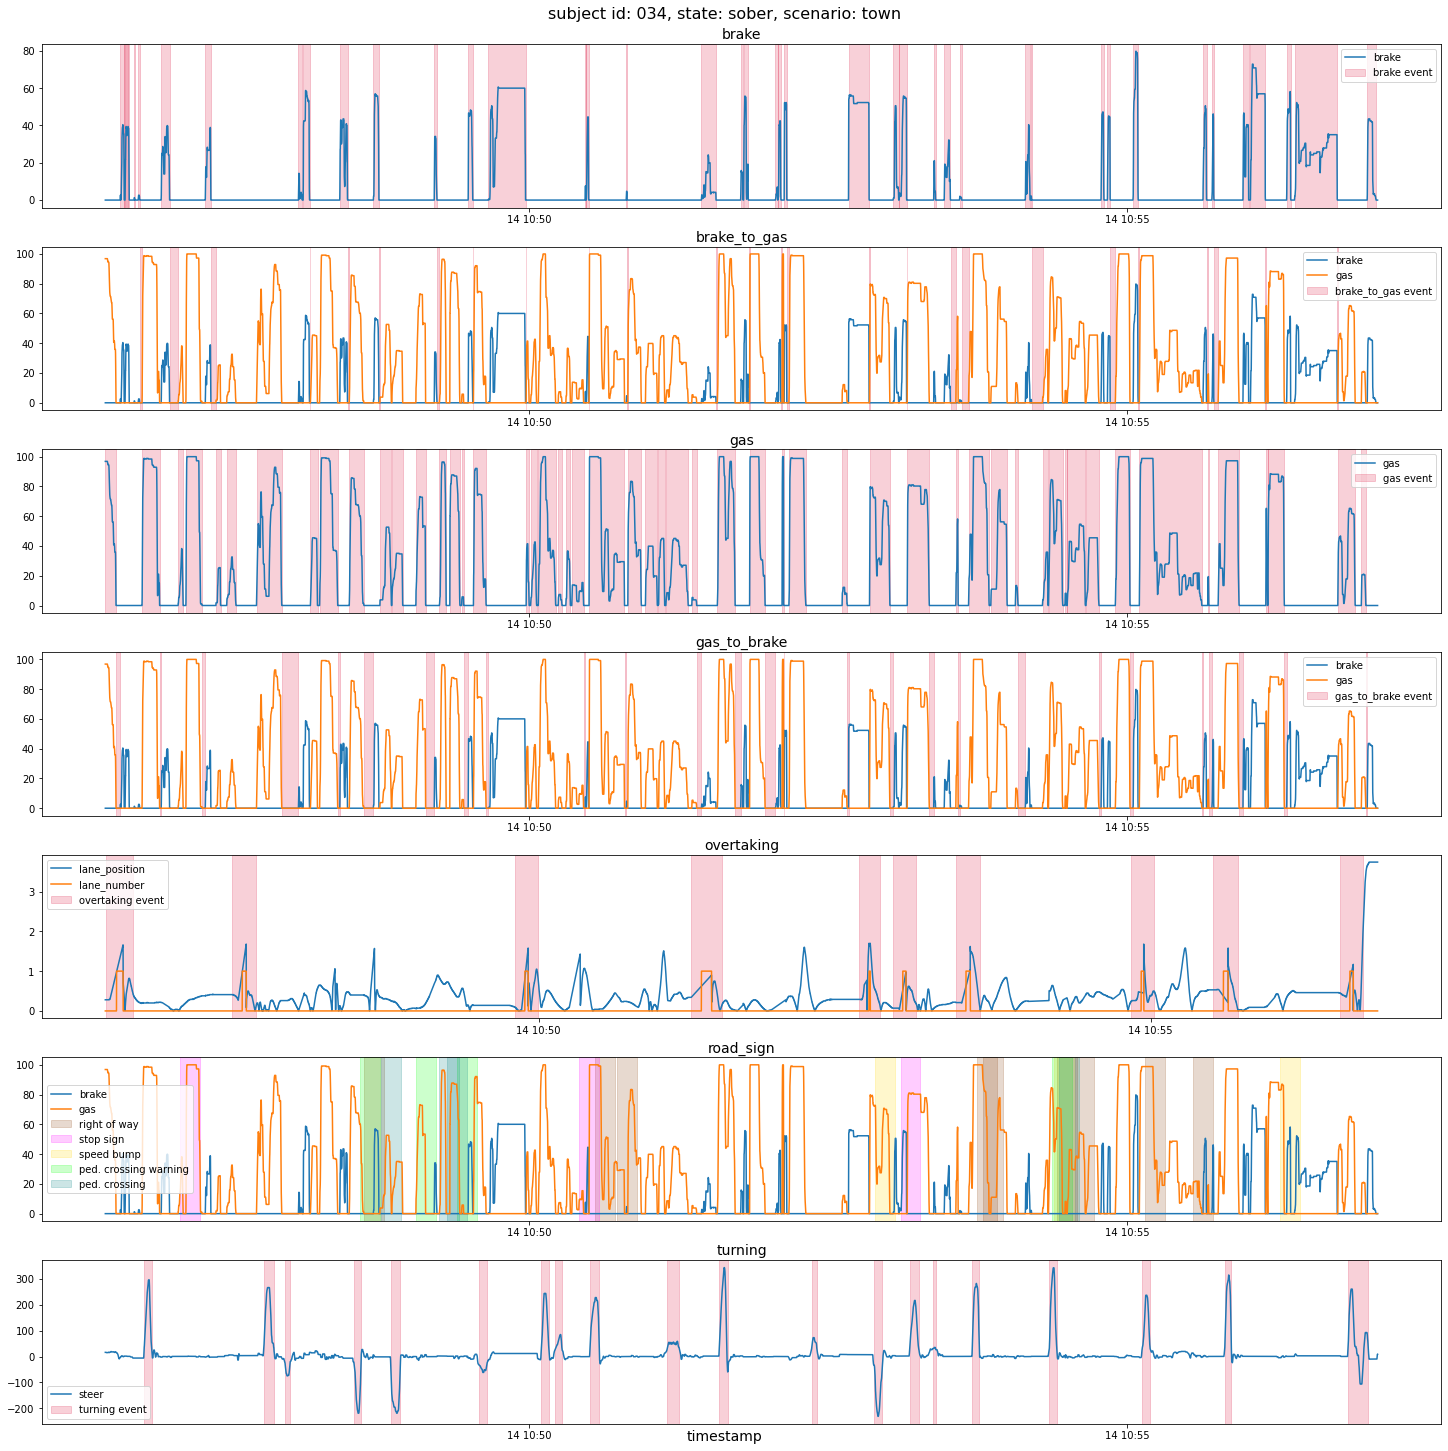

In [4]:
#%matplotlib widget
import pandas as pd
import numpy as np
import plotting_util
import matplotlib.pyplot as plt
import random
from datetime import timedelta

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

ROAD_SIGN_INFO = {
    1: ['crimson', 'speed limit 30', '-'],
    2: ['crimson', 'speed limit 50', '--'],
    140: ['crimson', 'speed limit 60', '-.'],
    141: ['crimson', 'speed limit 80', ':'],
    4: ['crimson', 'speed limit 100', '-'],
    5: ['crimson', 'speed limit 120', '--'],
    20: ['saddlebrown', 'right of way'],
    24: ['fuchsia', 'stop sign'],
    94: ['gold', 'speed bump'],
    107: ['lime', 'ped. crossing warning'],
    114: ['teal', 'ped. crossing']
}

SIGNALS = {
    'brake': ['brake'],
    'brake_to_gas': ['brake', 'gas'],
    'gas': ['gas'],
    'gas_to_brake': ['brake', 'gas'],
    'overtaking': ['lane_position', 'lane_number'],
    'road_sign': ['brake', 'gas'],
    'turning': ['steer']
    }

STATES = ['above', 'below', 'sober']

SCENARIOS = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')
s_id = '034'#random.choice(np.unique(can_data['subject_id']))
state = 'sober'#random.choice(STATES)
scenario = 'town'#random.choice(SCENARIOS)
can_data_subject = can_data[
    (can_data['subject_id'] == s_id) & 
    (can_data['subject_state'] == state) & 
    (can_data['subject_scenario'] == scenario)
    ]
fig, axes = plotting_util.create_plot(len(EVENTS), 1, constrained_layout=True)
plotting_util.set_figure_size(fig, 20, 20)
plotting_util.set_fig_xlabel(fig, 'timestamp', ypos=0.0)
plotting_util.set_fig_title(fig, 'subject id: {}, state: {}, scenario: {}'.format(s_id, state, scenario))
for i, e in enumerate(EVENTS):
    event_data = pd.read_parquet('out/can_data_{}_events.parquet'.format(e))
    try:
        event_data_subject = event_data.loc[s_id, state, scenario, :]
    except KeyError:
        print('no data for event {}'.format(e))
        continue
    timestamps_start = event_data_subject.index.get_level_values('datetime').to_numpy()
    durations = event_data_subject['duration'].to_numpy()
    timestamps_end = timestamps_start + np.array(
        [timedelta(milliseconds=duration*1000) for duration in durations]
        )
    for signal in SIGNALS[e]:
        h = axes[i].plot(can_data_subject['timestamp'], can_data_subject[signal], label=signal)
    sign_labels = set()
    for j, (start, end) in enumerate(zip(timestamps_start, timestamps_end)):
        if e == 'road_sign':
            sign_info = ROAD_SIGN_INFO[event_data_subject.iloc[j]['sign_type']]
            sign_color = sign_info[0]
            sign_label = sign_info[1]
            if 'speed limit' in sign_label:
                sign_linestyle = sign_info[2]
                axes[i].axvspan(
                    start, 
                    end, 
                    color=sign_color, 
                    label=sign_label if sign_label not in sign_labels else '',
                    linestyle=sign_linestyle,
                    linewidth=2,
                    alpha=0.2
                    )
            else:
                axes[i].axvspan(
                    start, 
                    end, 
                    color=sign_color, 
                    label=sign_label if sign_label not in sign_labels else '',
                    alpha=0.2
                    )
            sign_labels.add(sign_label)
        else:
            axes[i].axvspan(start, end, color='crimson', alpha=0.2, label='{} event'.format(e) if j == 0 else '')
    plotting_util.set_ax_title(axes[i], e)
    axes[i].legend()
plt.savefig('out/event_indication_plots.png')